# AFD sur $\mathbb{R}^{p}$

Nous allons réaliser l'**analyse factorielle discriminante (AFD)** sur nos données des parties précédentes. Il s'agit d'une technique statistique qui vise à décrire, expliquer et prédire l’appartenance à des classes prédéfinies d'un ensemble d'observations (nos individus) à partir d'une série de variables prédictives, en se basant sur la décomposition de Huygens de l'inertie totale comme somme de l'**inertie inter-classe** et de l'**inertie intra-classe**. 

L'objectif est donc de trouver des facteurs, combinaisons linéaires des variables quantitatives de départ, qui séparent au mieux les différentes classes.

## Import des modules

In [287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Import et prétraitement des données

Nous importons les données des parties précédentes:

In [288]:
data = pd.read_csv('Ionosphere.csv', delimiter=';', decimal=".",  error_bad_lines=False)
train = pd.read_csv('train.csv', delimiter=';',decimal=",",  error_bad_lines=False)
test = pd.read_csv('test.csv', delimiter=';',decimal=",",  error_bad_lines=False)
tr = train.copy()
te = test.copy()
del test["Unnamed: 0"]
del train["Unnamed: 0"]

Explicitons les différentes classes:

In [289]:
groupes = list(set(data["class"]))
groupes

['g', 'b']

Rassemblons les données suivant leurs classes: "b" et "g".

In [290]:
data_groupe_g = train.loc[train["class"] == "g"]
data_groupe_b = train.loc[train["class"] == "b"]

In [291]:
del data_groupe_b["class"]
del data_groupe_g["class"]

Une fois cela fait, calculons désormais les matrices de variances inter et intra-classe:

## Calcul de la matrice de variance intra-classe $W$

Centrons nos données et calculons les deux matrices de variances de chaque classe $W_g$ et $W_b$.

In [292]:
n_g = len(data_groupe_g)
n_b = len(data_groupe_b)

In [293]:
def centrage(data):
    data_centree = data.copy()
    for col in data.columns :
        data_centree[col] = (data_centree[col]-data.mean()[col])
    return data_centree

def matrice_cov(data):
    data_transposee = np.transpose(data)
    p, n = data_transposee.shape
    cov_data = np.dot(data_transposee,data)/n
    return cov_data

In [294]:
W_g = matrice_cov(centrage(data_groupe_g))
W_b = matrice_cov(centrage(data_groupe_b))

Nous pouvons en déduire la matrice de variance intra-classe donnée par la formule $W = \frac {1}{n} \sum_{k} n_{k} \times W_{k}$.

In [295]:
n = len(train)
W = (n_g * W_g + n_b * W_b)/n 
W

array([[ 0.18531541,  0.04748837,  0.05221866, ..., -0.00270268,
         0.03304089,  0.01414866],
       [ 0.04748837,  0.18102275, -0.00411242, ..., -0.0193937 ,
        -0.0234831 ,  0.00318927],
       [ 0.05221866, -0.00411242,  0.1816105 , ...,  0.00655465,
         0.06452714, -0.01616549],
       ...,
       [-0.00270268, -0.0193937 ,  0.00655465, ...,  0.22009248,
        -0.02570962,  0.13014747],
       [ 0.03304089, -0.0234831 ,  0.06452714, ..., -0.02570962,
         0.25650154, -0.045066  ],
       [ 0.01414866,  0.00318927, -0.01616549, ...,  0.13014747,
        -0.045066  ,  0.20947581]])

## Calcul de la matrice de variance inter-classe $B$ 

La matrice de variance inter-classe donne la dispertion des centroïdes des classes autour du centre de gravité global, et est défine par $B = \frac {1}{n} \sum _{k}n_{k}({}^{t}(\mu _{k}-\mu ))(\mu _{k}-\mu )$, où $\mu$ est le centre de gravité du nuage de points global et $\mu_k$ le centre de gravité de la classe $k$.

Calculons $\mu_g$ et $\mu_b$ (nous travaillons avec deux classes uniquement ici):

In [296]:
del train["class"]
mu_g = []
for col in data_groupe_g.columns :
    mu_g.append(data_groupe_g.mean()[col])
mu_b = []
for col in data_groupe_b.columns :
    mu_b.append(data_groupe_b.mean()[col])
mu = []
for col in train.columns :
    mu.append(train.mean()[col])

In [297]:
mu_g = pd.DataFrame(mu_g)
mu_b = pd.DataFrame(mu_b)
mu = pd.DataFrame(mu)

On peut donc finalement calculer notre matrice $B$:

In [298]:
B_g = np.dot(mu_g - mu, pd.DataFrame.transpose(mu_g - mu))
B_b = np.dot(mu_b - mu, pd.DataFrame.transpose(mu_b - mu))
B = (n_g * B_g + n_b * B_b)/n
B

array([[ 0.06345239,  0.01595062,  0.06203811, ...,  0.00327825,
         0.02925308, -0.00319334],
       [ 0.01595062,  0.00400966,  0.0155951 , ...,  0.00082408,
         0.00735362, -0.00080274],
       [ 0.06203811,  0.0155951 ,  0.06065535, ...,  0.00320518,
         0.02860107, -0.00312217],
       ...,
       [ 0.00327825,  0.00082408,  0.00320518, ...,  0.00016937,
         0.00151135, -0.00016498],
       [ 0.02925308,  0.00735362,  0.02860107, ...,  0.00151135,
         0.01348638, -0.00147221],
       [-0.00319334, -0.00080274, -0.00312217, ..., -0.00016498,
        -0.00147221,  0.00016071]])

## Calcul de la matrice de variance totale $V$ 

On démontre de variance totale $V$ se décompose simplement comme somme de la variance inter-classe et de la variance intra-classe: $V=W+B$.

In [299]:
V = B + W
V

array([[ 0.2487678 ,  0.06343899,  0.11425677, ...,  0.00057557,
         0.06229397,  0.01095532],
       [ 0.06343899,  0.18503241,  0.01148268, ..., -0.01856962,
        -0.01612948,  0.00238653],
       [ 0.11425677,  0.01148268,  0.24226585, ...,  0.00975983,
         0.0931282 , -0.01928765],
       ...,
       [ 0.00057557, -0.01856962,  0.00975983, ...,  0.22026185,
        -0.02419827,  0.12998248],
       [ 0.06229397, -0.01612948,  0.0931282 , ..., -0.02419827,
         0.26998792, -0.04653821],
       [ 0.01095532,  0.00238653, -0.01928765, ...,  0.12998248,
        -0.04653821,  0.20963652]])

Calculons désormais la matrice de variance totale $\Sigma$ de la manière classique, et vérifions que l'on a bien égalité comme énoncé par le théorème de Huygens:

In [300]:
Sigma = matrice_cov(centrage(train.iloc[:,:32]))
Sigma

array([[ 0.2487678 ,  0.06343899,  0.11425677, ...,  0.00057557,
         0.06229397,  0.01095532],
       [ 0.06343899,  0.18503241,  0.01148268, ..., -0.01856962,
        -0.01612948,  0.00238653],
       [ 0.11425677,  0.01148268,  0.24226585, ...,  0.00975983,
         0.0931282 , -0.01928765],
       ...,
       [ 0.00057557, -0.01856962,  0.00975983, ...,  0.22026185,
        -0.02419827,  0.12998248],
       [ 0.06229397, -0.01612948,  0.0931282 , ..., -0.02419827,
         0.26998792, -0.04653821],
       [ 0.01095532,  0.00238653, -0.01928765, ...,  0.12998248,
        -0.04653821,  0.20963652]])

In [301]:
np.linalg.norm(Sigma-V)

2.0365533782034384e-15

On remarque que $\lVert \Sigma - V \rVert$ est quasi-nul. En réalité, cette quantité est nulle, le résidu est simplement dû à l'accumulation d'erreur du calcul approché des flottant qui n'est pas exact.

Ceci est normal en vertu du théorème d’Huyghens (qui est la généralisation mutlidimensionnelle de la formule de décomposition de la variance), qui affirme $\Sigma = V = B + W$.

## Recherche d'axes et de variables discriminantes 

L'objectif désormais est de trouver les axes factoriels, décrits par des variables discriminantes qui sont combinaisons linéaires des variables quantitatives de départ, qui séparent au mieux les différentes classes.

Le critère sur le premier axe principal, dirigé par un certain vecteur $u$, est donc à la fois minimiser la dispertion intraclasse ($u'Wu$) et de maximiser la dispertion interclasse ($u'Bu$). La résolution de ce problème avec ces deux contraintes simultanées est impossible. 

On montre qu'un bon compromis est atteint en maximisant le rapport de la variance interclasse sur la variance totale, c'est-à-dire de trouver le vecteur $v$ vérifiant : $\partial_v(\frac{v'Bv}{v'\Sigma v}) = 0$.

En posant $0<\lambda=\frac{v'Bv}{v'\Sigma v}<1$, on  se ramène après quelques calculs à résoudre le problème aux valeurs propres $\Sigma^{-1}Bv=\lambda v$.

On sait également montrer de plus que  $\Sigma^{-1}B$ possède au plus $q-1$ valeurs propres non nulles, avec $q$ le nombre de classes. On trouve donc $q-1$ axes factoriels de projection.

Dans notre cas, nous avons 2 classes uniquement ($q=2$), on trouve donc un unique axe factoriel sur lequel projeter nos données.

Réalisons donc la réduction:

In [302]:
def val_vec_pro(data, k = 10**3) :
    ValeursPropres, VecteursPropres = np.linalg.eig(data)
    # ordonner les valeurs propres
    ordre = ValeursPropres.argsort()[::-1]
    ValeursPropres = ValeursPropres[ordre]
    VecteursPropres = VecteursPropres[:,ordre]
    return ValeursPropres[:k], VecteursPropres[:k]

On détermine les valeurs et vecteurs propres de la matrice $\Sigma^{-1}B$ :

In [303]:
val_prop, vect_prop = val_vec_pro(np.dot(np.linalg.inv(Sigma), B))

In [304]:
vect_prop.astype("float")[:,0]

array([ 0.20199987,  0.07282878,  0.14139644,  0.13953027,  0.15793396,
        0.18649204,  0.43806908,  0.10538869, -0.11233482, -0.14837356,
        0.06702495,  0.04158587, -0.07767611, -0.01821725, -0.03244738,
       -0.16571747, -0.19083055,  0.13786548, -0.0566079 , -0.35530645,
        0.11208504,  0.07538155,  0.07971692,  0.28364556, -0.29732504,
       -0.04297663,  0.15469899,  0.16522062,  0.123553  ,  0.18997549,
        0.0116793 , -0.30506388])

In [305]:
val_prop.astype("float")

array([ 6.00206990e-01,  4.10101134e-16,  2.65210490e-16,  7.87010957e-17,
        7.87010957e-17,  6.80196466e-17,  3.06598994e-17,  2.46530224e-17,
        2.46530224e-17,  1.54294844e-17,  1.54294844e-17,  1.26422776e-17,
        1.26422776e-17,  1.37225883e-18,  1.37225883e-18, -5.49480444e-19,
       -5.49480444e-19, -7.37865912e-18, -7.37865912e-18, -1.57427523e-17,
       -2.07092181e-17, -2.07092181e-17, -3.43768608e-17, -3.43768608e-17,
       -5.02471411e-17, -5.02471411e-17, -8.09566643e-17, -8.09566643e-17,
       -9.48845453e-17, -9.48845453e-17, -1.97335386e-16, -5.60157250e-16])

La diagonalisation de la matrice $\Sigma^{-1} B$ donne théoriquement des valeurs propres entre 0 et 1, ce qui facilite leur interprétation, valeur propre = pouvoir discriminant de l'axe. Sur R la fonction "lda" dans la librairie "MASS" donne la diagonalisation de la matrice $W^{-1} B$, les valeurs propres ne sont pas les mêmes, mais elles sont reliées par la formule: $\lambda_{\Sigma_{-1} B} = \frac{\mu_{W_{-1} B}}{\mu_{W_{-1} B} + 1}$. 


Pour chaque valeur propre $\lambda_{i}$ on calcule: $\frac{\lambda_{i}}{\sum{\lambda_{k}}}$

In [306]:
sum_eig = sum(val_prop.astype("float"))
l=[]
for i in val_prop.astype("float"):
   l.append(i/sum_eig)
print(l)

[1.0000000000000004, 6.832661752381911e-16, 4.4186504754735983e-16, 1.3112325764651203e-16, 1.3112325764651203e-16, 1.13326981867828e-16, 5.1082209776356626e-17, 4.107420074181144e-17, 4.107420074181144e-17, 2.5706938950259397e-17, 2.5706938950259397e-17, 2.1063196288013695e-17, 2.1063196288013695e-17, 2.2863093168836547e-18, 2.2863093168836547e-18, -9.15484913452482e-19, -9.15484913452482e-19, -1.2293524148753847e-17, -1.2293524148753847e-17, -2.622887201865067e-17, -3.450346038029198e-17, -3.450346038029198e-17, -5.727500918392291e-17, -5.727500918392291e-17, -8.371635450453105e-17, -8.371635450453105e-17, -1.3488124215402105e-16, -1.3488124215402105e-16, -1.580863717606874e-16, -1.580863717606874e-16, -3.2877888772245946e-16, -9.33273452791918e-16]


On remarque que la plus grande valeur propre est la seule significative ce qui est normale car le nombre de composantes sur lesquelles on projette = K - 1, avec K le nombre de classes dans ce cas K = 2.

Les nouvelles coordonnées sur cet axe sont ensuite obtenues par un produit scalaire entre les points et notre vecteur propre (puisque c'est une base orthonormée à 1 vecteur):

In [307]:
new_coord = np.dot(np.array(train),vect_prop.astype(float)[:,0])

On différencie pour chaque classe:

In [308]:
new_coord_train_g = np.array(data_groupe_g.dot(vect_prop.astype(float)[:,0]))
new_coord_train_b = np.array(data_groupe_b.dot(vect_prop.astype(float)[:,0]))

On visualise graphiquement la classification des individus par rapport à notre vecteur propre:

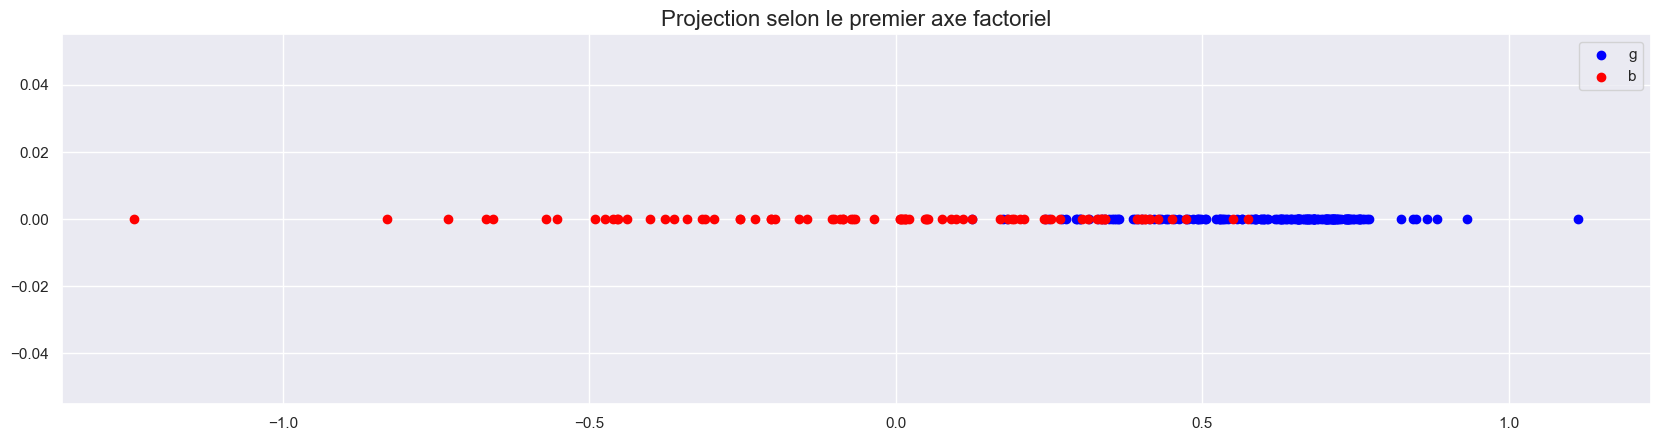

In [309]:
fig = plt.figure() 
fig.set_figwidth(20.5)
plt.scatter(new_coord_train_g[:], np.zeros(len(new_coord_train_g)),color='blue')
plt.scatter(new_coord_train_b[:], np.zeros(len(new_coord_train_b)),color='red')
plt.legend(["g","b"])
plt.title('Projection selon le premier axe factoriel', fontsize=16)
plt.show()

La projection sur cete axe de l'AFD permet de mettre en évidence la séparation entre les deux classes **g** et **b**. C'est bien là l'intérêt de l'AFD descriptive. On observe néanmoins, au milieu, que les deux classes s'entremêlent: c'est ces individus qui sont le plus "difficile" à classfier avec ce modèle. Ont-il un rôle particulier ? C'est ce que nous étudions dans la suite:

### Qualités de projections individuelles

On projette sur un seul axe factoriel, la qualité de projection dans ce cas se définit comme suit: $Q_{i} = \frac{1}{n}\frac{C_{i}^2}{\lambda}$, avec $C_{i}$ la coordonnée du point i sur notre axe factoriel, et $\lambda$ notre valeur propre unique.

In [310]:
del test["class"]
def qpi(i,c):
    return c[i]**2/(val_prop[0]*n)

In [311]:
centree_test = centrage(test)
new_coord_centré_test = np.dot(np.array(centree_test),vect_prop.astype(float)[:,0])

Q_proj_test = [qpi(i,new_coord_centré_test) for i in range(len(new_coord_centré_test))]

Une fois que l'on a calculé nos qualités de projections individuelle, intéressons-nous aux 5 individus les moins bien projetés sur cet axe:

In [312]:
K = 5
res = sorted(range(len(Q_proj_test)), key = lambda sub: Q_proj_test[sub])[:K]
res_indice_data = []
for i in range(len(res)):
    res_indice_data.append(te.iloc[res[i]]["Unnamed: 0"]-1)
print("Les indices en tant qu'éléments de l'ensemble test:")
print([x+1 for x in res])
print("\nLes indices en tant qu'éléments du dataset d'origine:")
print([x+1 for x in res_indice_data])

Les indices en tant qu'éléments de l'ensemble test:
[32, 77, 22, 4, 10]

Les indices en tant qu'éléments du dataset d'origine:
[110, 238, 64, 8, 18]


Ce ne sont pas les même individus que les moins bien projetés de l'ACP. C'était prévisible et attendu: l'ACP n'a rien avoir avec la classification, elle ne considère que les variables quantitatives et les individus mal projetés sont ceux qui ont des coordonnées importantes sur les composantes à faible variance expliquée. Les individus mal projetés en AFD sont ceux qui sont difficile à classifier avec notre modèle: ils présentent des caractéristiques qui peuvent être associées aux deux classes (ou à aucune des classes).

Ce ne sont pas non plus les même individus que les points avec le plus haut score d'anomalie issue de l'algorithme des forêts d'isolement. La forêt d'isolement est une boite noire, elle considère des milliers de paramètres pour décrire les individus à forte anomalies. L'AFD ne considère que leur qualité de projection sur l'axe optimal vis à vis de la classification, ce qui est très restrictif.

In [313]:
x=[]
for i in res:
    x.append(new_coord_centré_test[i])

In [314]:
data_test_g = te.loc[te["class"] == "g"]
data_test_b = te.loc[te["class"] == "b"]
del data_test_g["class"]
del data_test_b["class"]
del data_test_g["Unnamed: 0"]
del data_test_b["Unnamed: 0"]

In [315]:
new_coord_test_g = np.array(data_test_g.dot(vect_prop.astype(float)[:,0]))
new_coord_test_b = np.array(data_test_g.dot(vect_prop.astype(float)[:,0]))

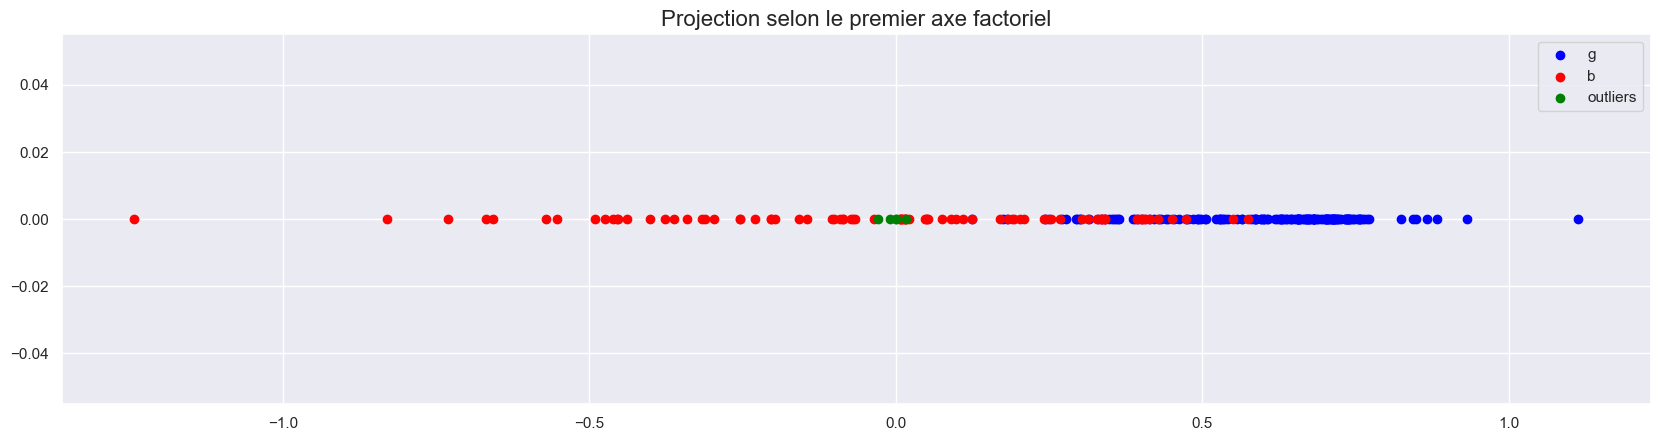

In [316]:
fig = plt.figure() 
fig.set_figwidth(20.5)
plt.scatter(new_coord_train_g[:], np.zeros(len(new_coord_train_g)),color='blue')
plt.scatter(new_coord_train_b[:], np.zeros(len(new_coord_train_b)),color='red')
plt.scatter(x,np.zeros(5),color='green')
plt.legend(["g","b","outliers"])
plt.title('Projection selon le premier axe factoriel', fontsize=16)
plt.show()

On voit, comme prévue avec la formule données pour la qualité de projection en AFD, que les individus les plus mal projetés sont situés au centre de l'axe. Mais on se rend compte, en étudiant la projection, que ce choix n'est peut-être pas optimal: il est clair que le "seuil" séparant les deux classes et situé plus à droite que l'origine. Ceci peut être une conséquence du fait que sur notre échantillon (**test**), les classes **g** et **b** ne sont pas uniformément réparties (il n'y a pas égalité des cardinaux entre les deux classes). Notre définition de la qualité de projection ici est à revoir.

## Mise en oeuvre de l'AFD prédictive

### Fonction discriminante et règle de Fisher
Le score de Fisher est défini comme suit: $f(x) = (x - \mu_{g})^{T}W^{-1}(x - \mu_{g}) - (x - \mu_{b})^{T}W^{-1}(x - \mu_{b})$, avec x un individu et $\mu_{g}, \mu_{b}$ comme définies avant.

L'interprétation: si f(x) > 0, l'individu est classé dans le groupe "b", et vice versa.

In [332]:
def score_fisher(x):
    x = np.array(x)
    f_g = np.linalg.multi_dot([x - np.array(np.transpose(mu_g)), np.linalg.inv(W), np.transpose(x - np.array(np.transpose(mu_g)))])
    f_b = np.linalg.multi_dot([x - np.array(np.transpose(mu_b)), np.linalg.inv(W), np.transpose(x - np.array(np.transpose(mu_b)))])
    f = f_g - f_b
    if f > 0: 
        return "b"
    else:
        return "g"

In [333]:
score_fisher(test[:][0:1])

'g'

On va tester sur les données test pour comparer avec les résultats déjà existantes.

In [334]:
donnees = np.array((X_test).copy())
scores = []

In [335]:
test[:][0:1]

,a01,a02,a03,a04,a05,a06,a07,a08,a09,a10,...,a23,a24,a25,a26,a27,a28,a29,a30,a31,a32
0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.0,0.0376,0.85243,-0.17755,...,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.3409,0.42267,-0.54487,0.18641,-0.453


In [336]:
coord_acp

,0,1,2,3,4,5,6,7,8,9,10
0,0.845346,-0.904100,0.860177,0.277647,0.576287,-0.129882,-0.240280,0.020483,-0.451026,0.043456,0.031595
1,-0.702356,-0.976913,1.230992,-0.836346,1.004040,0.606400,0.123228,0.001717,-1.208398,0.075685,-0.729596
2,1.104155,-0.384394,0.238528,0.480572,0.301979,-0.258157,-0.205639,0.090898,-0.163315,-0.061304,0.013977
3,-0.497469,0.195276,-0.364778,-2.096464,-0.135063,0.485935,0.897938,0.879155,-0.005744,0.970383,-0.635662
4,1.508906,-1.479972,1.144598,0.311900,0.462807,-0.506573,-0.311559,0.110703,-0.396230,-0.179601,-0.020847
...,...,...,...,...,...,...,...,...,...,...,...
100,-1.960465,-0.927820,-1.521135,-0.319831,-1.257892,1.252897,0.459297,0.256810,-0.516791,0.230575,-0.094118
101,1.501060,-0.063715,-0.102028,0.076002,-0.072368,-0.224772,0.045515,0.030102,0.170770,-0.080040,-0.055271
102,1.378390,0.081221,-0.060778,0.247812,-0.123406,-0.087705,0.037842,0.153704,-0.001341,-0.034301,0.034470
103,1.777579,-0.059035,-0.083886,0.379550,-0.196302,-0.051681,0.332042,-0.001168,0.205403,-0.018128,0.115304


In [337]:
n = np.shape(test)[0]
class_pred = []
for i in range(n):
    class_pred.append(score_fisher(test[:][i:i+1]))

In [338]:
score = 0
for i in range(n):
    if te.iloc[i]['class'] == class_pred[i]:
        score += 1

In [339]:
score/n

0.819047619047619

In [340]:
class_reel = list(te.iloc[:]['class'])

In [341]:
from sklearn.metrics import confusion_matrix
cm_AFD = confusion_matrix(class_reel ,class_pred)

In [342]:
cm_AFD

array([[27, 15],
       [ 4, 59]], dtype=int64)

On calcule le taux de précision de l'AFD:

In [343]:
(cm_AFD[0][0]+cm_AFD[1][1])/(sum(cm_AFD[0]) + sum(cm_AFD[1]))

0.819047619047619

On a déjà trouvé précédemment la matrice de confusion des forets aléatoires:

In [344]:
cm_IF = np.array([[42, 2],[0, 62]])

In [345]:
cm_IF

array([[42,  2],
       [ 0, 62]])

On calcule le taux de précision des forets aléatoires:

In [346]:
(cm_IF[0][0]+cm_IF[1][1])/(sum(cm_IF[0]) + sum(cm_IF[1]))

0.9811320754716981

Le taux de précision des forets aléatoires est très supérieur à celui de l'AFD, ceci est du à la grande sensibilité de cette dernière aux Outliers. De plus l'algorithme des forets aléatoires est très poussé par rapport à l'AFD simple.

## Effet de la réduction de dimension

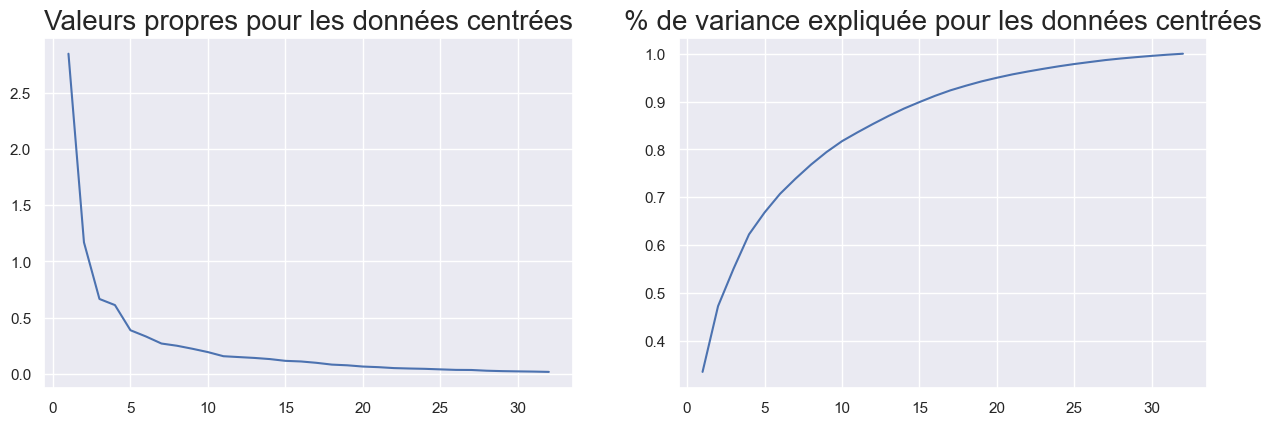

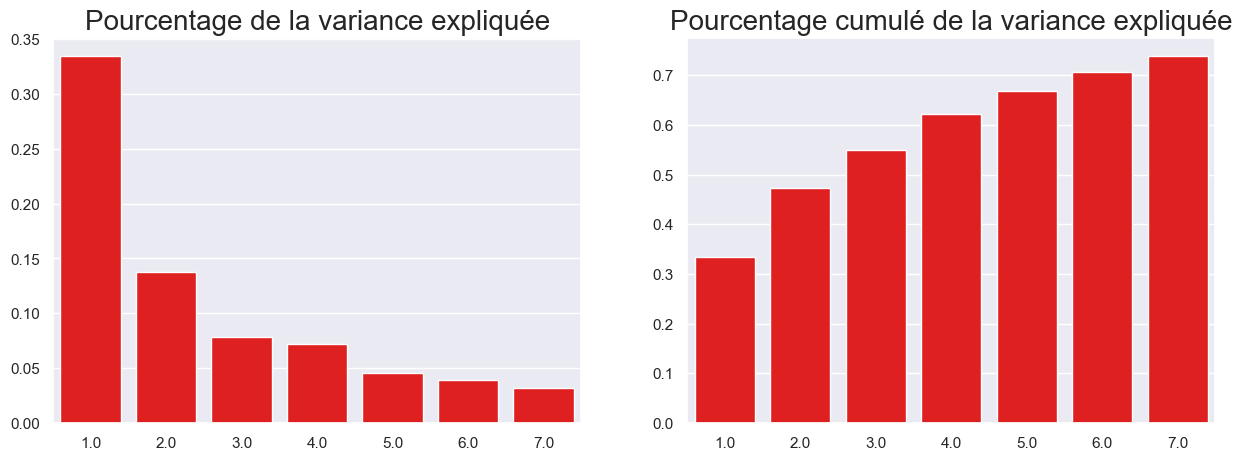

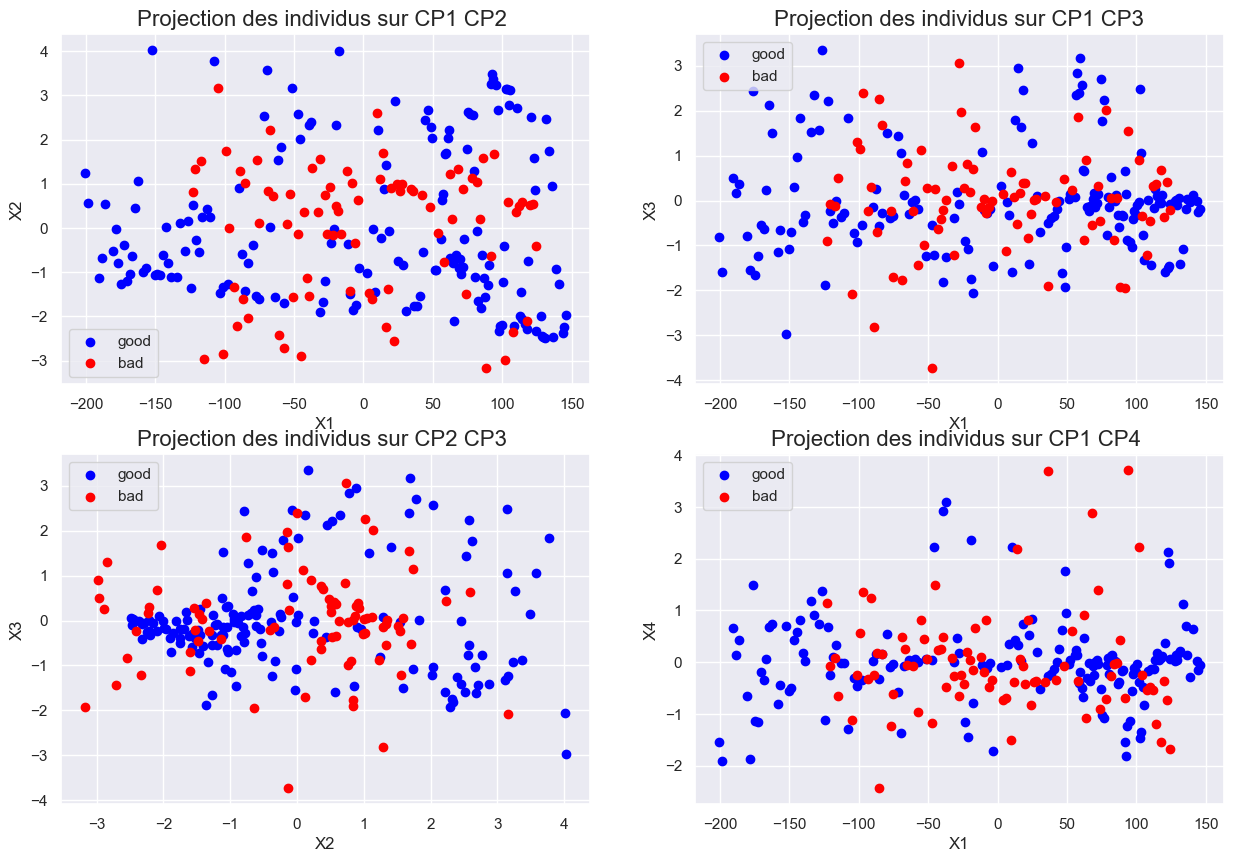

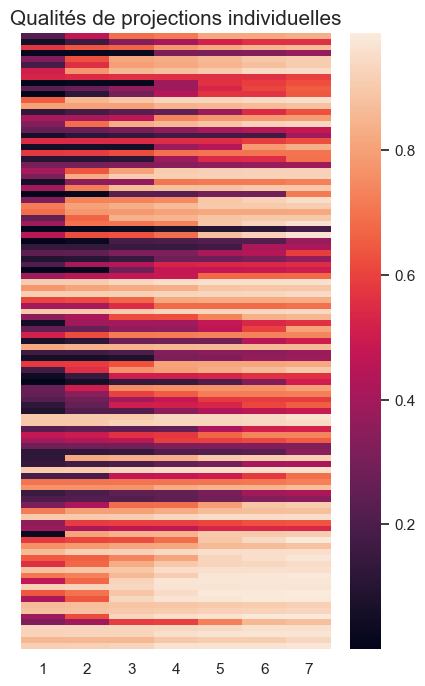

Les indices en tant qu'éléments de l'ensemble test:
[34, 71, 72, 80, 39]

Les indices en tant qu'éléments du dataset d'origine:
[113, 223, 225, 253, 129]


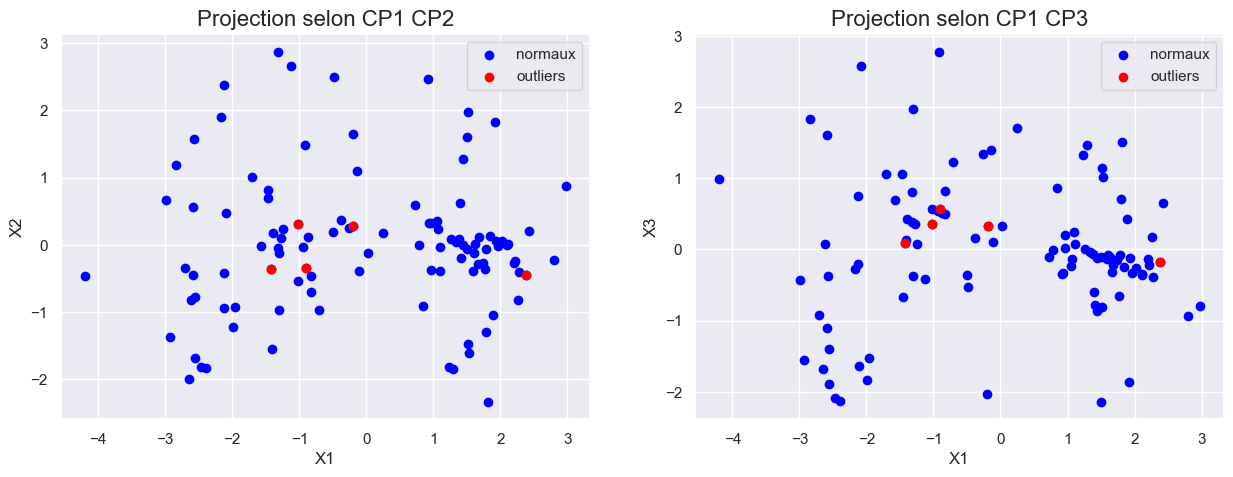

Les indices en tant qu'éléments de l'ensemble test_g:
[21, 42, 19, 27, 15]

Les indices en tant qu'éléments du dataset d'origine:
[140, 269, 124, 170, 106]
Les indices en tant qu'éléments de l'ensemble test_b:
[42, 38, 23, 28, 20]

Les indices en tant qu'éléments du dataset d'origine:
[253, 225, 159, 177, 129]


In [347]:
%run TP2_Mixte_partie_ACP.ipynb

Dans cette question, on fera une AFD suivie d'une ACP, on importe donc nos données réduites après ACP (projetées sur 7 composantes).

In [348]:
new_coord_centré_test

array([[ 0.84534564, -0.90410026,  0.86017653, ..., -0.09525242,
        -0.04498434,  0.06931671],
       [-0.70235563, -0.97691329,  1.23099229, ...,  0.14946615,
        -0.25421144,  0.02587376],
       [ 1.10415454, -0.38439426,  0.23852835, ...,  0.03936799,
         0.10954913,  0.07934381],
       ...,
       [ 1.37838974,  0.0812212 , -0.06077765, ..., -0.02014815,
        -0.0173995 ,  0.02942371],
       [ 1.77757883, -0.05903519, -0.08388584, ..., -0.00358707,
        -0.07428663,  0.0377585 ],
       [ 2.02438024,  0.06079109, -0.25806326, ..., -0.01954556,
        -0.02830192,  0.03507752]])

In [349]:
coord_acp = pd.DataFrame(new_coord_centré_test[:,0:11])

In [350]:
coord_acp["class"] = test["class"]
nca = coord_acp.copy()

In [351]:
coord_acp

,0,1,2,3,4,5,6,7,8,9,10,class
0,0.845346,-0.904100,0.860177,0.277647,0.576287,-0.129882,-0.240280,0.020483,-0.451026,0.043456,0.031595,g
1,-0.702356,-0.976913,1.230992,-0.836346,1.004040,0.606400,0.123228,0.001717,-1.208398,0.075685,-0.729596,b
2,1.104155,-0.384394,0.238528,0.480572,0.301979,-0.258157,-0.205639,0.090898,-0.163315,-0.061304,0.013977,g
3,-0.497469,0.195276,-0.364778,-2.096464,-0.135063,0.485935,0.897938,0.879155,-0.005744,0.970383,-0.635662,b
4,1.508906,-1.479972,1.144598,0.311900,0.462807,-0.506573,-0.311559,0.110703,-0.396230,-0.179601,-0.020847,g
...,...,...,...,...,...,...,...,...,...,...,...,...
100,-1.960465,-0.927820,-1.521135,-0.319831,-1.257892,1.252897,0.459297,0.256810,-0.516791,0.230575,-0.094118,g
101,1.501060,-0.063715,-0.102028,0.076002,-0.072368,-0.224772,0.045515,0.030102,0.170770,-0.080040,-0.055271,g
102,1.378390,0.081221,-0.060778,0.247812,-0.123406,-0.087705,0.037842,0.153704,-0.001341,-0.034301,0.034470,g
103,1.777579,-0.059035,-0.083886,0.379550,-0.196302,-0.051681,0.332042,-0.001168,0.205403,-0.018128,0.115304,g


Maintenant on fera l'AFD, on calcule $B$ et $\Sigma$ pour diagonaliser $\Sigma^{-1}B$.

In [352]:
coord_acp_g = coord_acp.loc[coord_acp["class"] == "g"]
coord_acp_b = coord_acp.loc[coord_acp["class"] == "b"]

In [353]:
del coord_acp_g["class"]
del coord_acp_b["class"]

In [354]:
m_g = len(coord_acp_g)
m_b = len(coord_acp_b)
m = len(coord_acp)

In [355]:
del coord_acp["class"]
mu_g_acp = []
for col in coord_acp_g.columns :
    mu_g_acp.append(coord_acp_g.mean()[col])
mu_b_acp = []
for col in coord_acp_b.columns :
    mu_b_acp.append(coord_acp_b.mean()[col])
mu_acp = []
for col in coord_acp.columns :
    mu_acp.append(coord_acp.mean()[col])

In [356]:
mu_g_acp = pd.DataFrame(mu_g_acp)
mu_b_acp = pd.DataFrame(mu_b_acp)
mu_acp = pd.DataFrame(mu_acp)

In [357]:
B_g_acp = np.dot(mu_g_acp - mu_acp, pd.DataFrame.transpose(mu_g_acp - mu_acp))
B_b_acp = np.dot(mu_b_acp - mu_acp, pd.DataFrame.transpose(mu_b_acp - mu_acp))
B_acp = (m_g * B_g_acp + m_b * B_b_acp)/m

In [358]:
Sigma_acp = matrice_cov(centrage(coord_acp))

In [359]:
val, vec = val_vec_pro(np.dot(np.linalg.inv(Sigma_acp), B_acp))

On trouve notre vecteur propre unique (un seul axe factoriel K = 1).

In [360]:
vec.astype(float)[:,0]

array([ 0.20059832, -0.21271544, -0.4515953 ,  0.56921379,  0.29785977,
       -0.229055  , -0.12718317,  0.43055265, -0.05126263, -0.19721913,
       -0.04804972])

On détermine les nouvelles coordonnées sur notre axe factoriel.

In [361]:
new_coord_acp = np.dot(np.array(coord_acp),vec.astype(float)[:,0])

On fait la prédiction à l'aide de la règle de Fisher comme fait précédemment.

In [362]:
def score_fisher_acp(x):
    x = np.array(x)
    f_g = np.linalg.multi_dot([x - np.array(np.transpose(mu_g_acp)), np.linalg.inv(Sigma_acp - B_acp), np.transpose(x - np.array(np.transpose(mu_g_acp)))])
    f_b = np.linalg.multi_dot([x - np.array(np.transpose(mu_b_acp)), np.linalg.inv(Sigma_acp - B_acp), np.transpose(x - np.array(np.transpose(mu_b_acp)))])
    f = f_g - f_b
    if f > 0: 
        return "b"
    else:
        return "g"

In [366]:
class_pred_acp = []
for i in range(m):
    class_pred_acp.append(score_fisher_acp(coord_acp[:][i:i+1]))

In [367]:
score_acp = 0
for i in range(m):
    if nca.iloc[i]['class'] == class_pred_acp[i]:
        score_acp += 1

Le taux de précision pour une ACP (7 composantes) suivie d'une AFD est:

In [368]:
score_acp/m

0.8952380952380953

On remarque que la réduction par ACP a un effet positif sur la discrimination par AFD. Ceci est compréhensible du fait que se limiter aux composantes principales permet d'atténuer l'effet des individus les moins bien projetés (les "outliers" de l'ACP) qui étaient succeptible d'également poser problème pour la classification (bien que l'on a vu que les 5 individus les moins bien projetés n'étaient pas forcément exactement les même dans les deux analyses factorielles). L'AFD est également connu pour avoir des problèmes de type calculatoire en haute dimension, du fait de l'instabilité et de la singularité de la matrice de variance-covariance. Réduire la dimension aux composantes principales semble donc être un point important avant de réaliser l'AFD. 

On pourrait maintenant se poser la question si cette réduction de la dimension impacte de la même manière les forêts aléatoires, reprenons notre modèle de forêt et appliquons le aux composantes principales uniquement: